In [1]:
!pip install -U --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found e

Load Dataset

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:14<00:00, 151MB/s]
100% 1.68G/1.68G [00:14<00:00, 127MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/deepfake-and-real-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from keras import layers
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import cv2
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy as logloss
from tensorflow.keras.metrics import categorical_accuracy
import pandas as pd
import os
from PIL import Image
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
import json

In [6]:
train_dir = '/content/Dataset/Train'
validation_dir = '/content/Dataset/Validation'
test_dir = '/content/Dataset/Test'

Load A Random Image

target folder /content/Dataset/Train/Real
Image shape: (256, 256, 3)


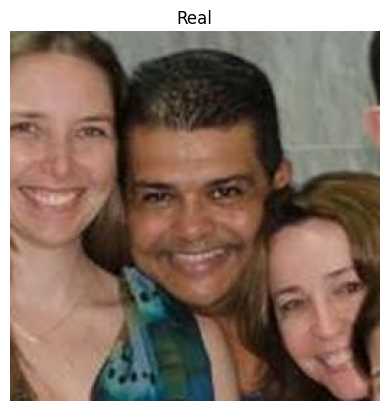

In [8]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir + "/" + target_class
  print(f"target folder {target_folder}")
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# View random image
img = view_random_image(target_dir=train_dir,
                        target_class="Real")

Image Preprocessing

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

TinyVGG model

In [11]:
# End to End TinyVGG Model

tf.random.set_seed(42)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=12, #5, 8
                        steps_per_epoch=128, # 44, 99, 128, 4k XD
                        validation_data=valid_data,
                        validation_steps=128)

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Epoch 1/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 64s 454ms/step - accuracy: 0.5102 - loss: 0.6945 - val_accuracy: 0.5122 - val_loss: 0.6926
Epoch 2/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - accuracy: 0.5061 - loss: 0.6934 - val_accuracy: 0.5393 - val_loss: 0.6895
Epoch 3/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 433ms/step - accuracy: 0.5579 - loss: 0.6896 - val_accuracy: 0.5581 - val_loss: 0.6896
Epoch 4/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - accuracy: 0.5659 - loss: 0.6810 - val_accuracy: 0.6008 - val_loss: 0.6598
Epoch 5/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 441ms/step - accuracy: 0.6192 - loss: 0.6582 - val_accuracy: 0.6072 - val_loss: 0.6635
Epoch 6/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 441ms/step - accuracy: 0.6020 - loss: 0.6653 - val_accuracy: 0.5975 - val_loss: 0.6671
Epoch 7/12
128/128 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.5970 - loss: 0.6624 - val_accuracy: 0.6392 - val_loss: 0.6

Accuracy: 0.6609

In [12]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 108, 108, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 106, 106, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 53, 53, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 28090)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          28,091 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

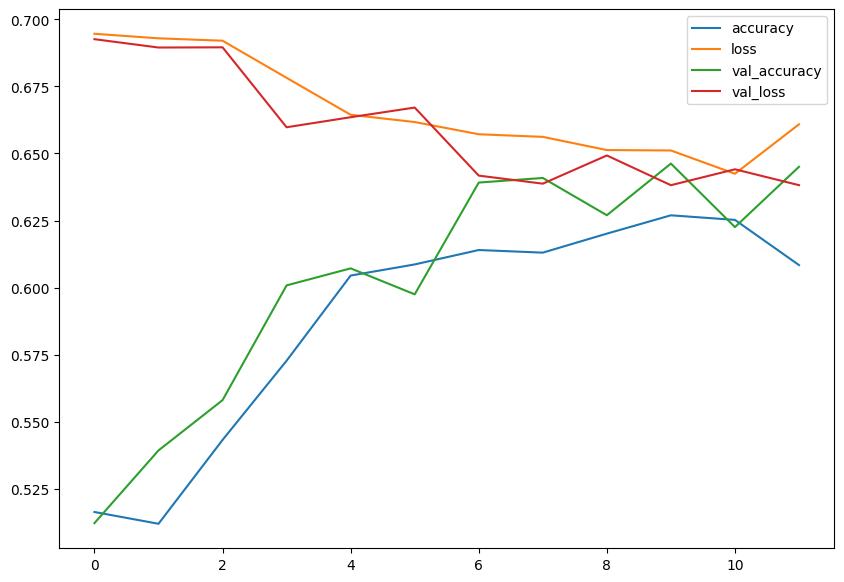

In [13]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

In [14]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

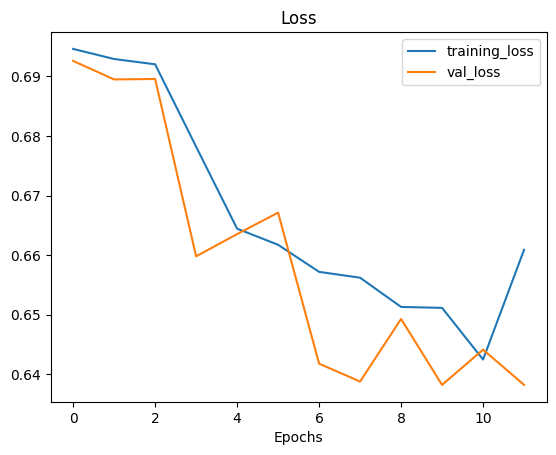

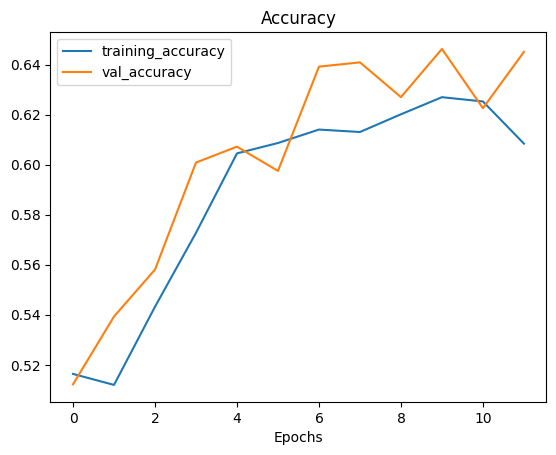

In [15]:
plot_loss_curves(history_1)

1- Similar to TinyVGG but with a MaxPooling layer after every Conv2D layer.
2- Potentially reducing the number of parameters and computational load, and hence reducing the risk of overfitting.

In [16]:
# model_2 with a MaxPool2D layer after every Conv2D layer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

tf.random.set_seed(42)

model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=64,
                        validation_data=valid_data,
                        validation_steps=64)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 440ms/step - accuracy: 0.4998 - loss: 0.6945 - val_accuracy: 0.5327 - val_loss: 0.6909
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 431ms/step - accuracy: 0.5358 - loss: 0.6900 - val_accuracy: 0.6025 - val_loss: 0.6755
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - accuracy: 0.5610 - loss: 0.6854 - val_accuracy: 0.5825 - val_loss: 0.6815
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 422ms/step - accuracy: 0.5897 - loss: 0.6794 - val_accuracy: 0.5054 - val_loss: 0.7751
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 421ms/step - accuracy: 0.5544 - loss: 0.6912 - val_accuracy: 0.5615 - val_loss: 0.6763


Accuracy: 0.5938

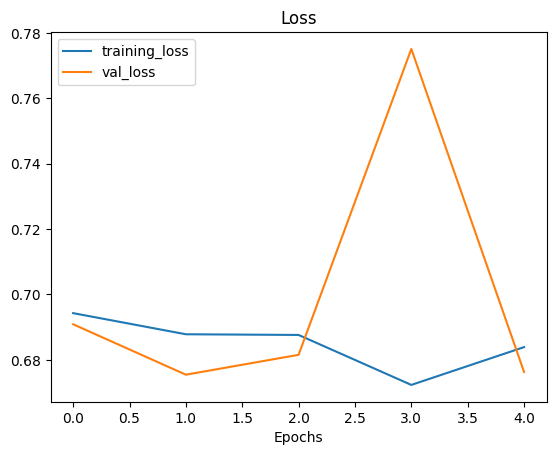

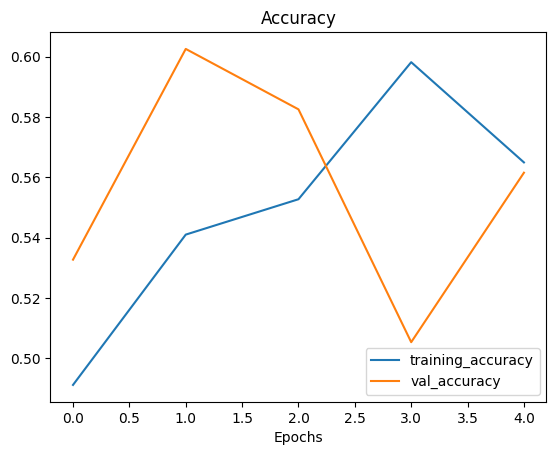

In [17]:
plot_loss_curves(history_2)

 Try DataAugmentation during image preprocessing.

Read an image file, preprocess it, and return the preprocessed image as a tensor

In [18]:
def load_and_prep_image(filename, img_shape=224):
  # Read in target file (an image)
  print(filename)
  img = tf.io.read_file(filename)

  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [19]:
train_img_path_1 = f"{test_dir}/Real/real_4.jpg"
train_img_path_2 = f"{test_dir}/Fake/fake_12.jpg"
train_img_real_1 = load_and_prep_image(train_img_path_1)
train_img_real_2 = load_and_prep_image(train_img_path_2)
train_img_real_1 = tf.expand_dims(train_img_real_1, axis=0)
train_img_real_2 = tf.expand_dims(train_img_real_2, axis=0)

/content/Dataset/Test/Real/real_4.jpg
/content/Dataset/Test/Fake/fake_12.jpg


In [20]:
pred_1 = model_2.predict(train_img_real_1)
pred_2 = model_2.predict(train_img_real_2)
print(pred_1)
print(pred_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.58326757]]
[[0.43832836]]


CNN Models with ResNet50

In [21]:
input_shape=(224,224,3)
batch_size=64


def build_model():
    densenet = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(64,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model


model_resnet = build_model()
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [22]:
tf.random.set_seed(42)
history = model_resnet.fit(train_data,
    epochs = 8,
    steps_per_epoch = 256,
    validation_data =valid_data,
    validation_steps = 256
)

Epoch 1/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 228s 610ms/step - accuracy: 0.5353 - loss: 0.8441 - val_accuracy: 0.4965 - val_loss: 0.6933
Epoch 2/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 140s 547ms/step - accuracy: 0.5047 - loss: 0.7791 - val_accuracy: 0.4972 - val_loss: 0.6932
Epoch 3/8


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


256/256 ━━━━━━━━━━━━━━━━━━━━ 148s 581ms/step - accuracy: 0.5045 - loss: 0.7399 - val_accuracy: 0.4984 - val_loss: 0.6939
Epoch 4/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 180s 706ms/step - accuracy: 0.5097 - loss: 0.7168 - val_accuracy: 0.5105 - val_loss: 0.6927
Epoch 5/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 150s 586ms/step - accuracy: 0.5164 - loss: 0.7023 - val_accuracy: 0.4940 - val_loss: 0.6983
Epoch 6/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 134s 526ms/step - accuracy: 0.5003 - loss: 0.7049 - val_accuracy: 0.5079 - val_loss: 0.7238
Epoch 7/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 175s 686ms/step - accuracy: 0.5137 - loss: 0.7008 - val_accuracy: 0.5525 - val_loss: 1.5079
Epoch 8/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 135s 529ms/step - accuracy: 0.5552 - loss: 0.6890 - val_accuracy: 0.4821 - val_loss: 0.6954


Accuracy: 0.9191

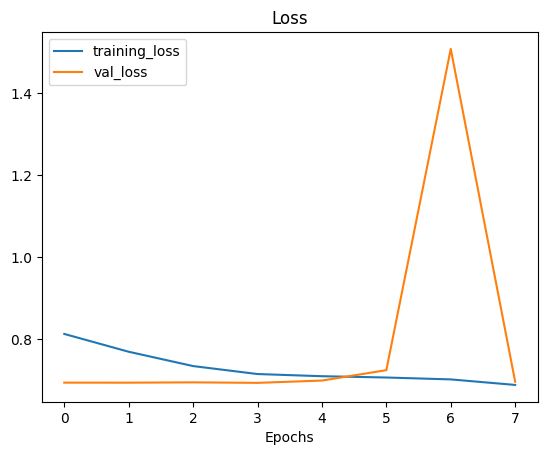

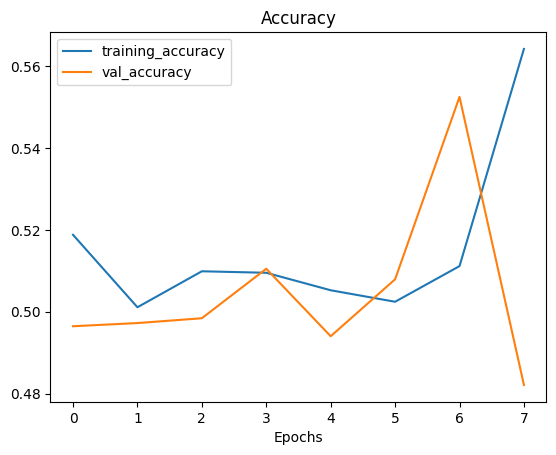

In [23]:
plot_loss_curves(history)

In [24]:
def build_model_2():
    densenet = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(128,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(64,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(32,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model


model_resnet_2 = build_model_2()
model_resnet_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [25]:
tf.random.set_seed(42)
history_resnet_2 = model_resnet_2.fit(train_data,
    epochs = 7,
    steps_per_epoch = 256,
    validation_data =valid_data,
    validation_steps = 256
)

Epoch 1/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 220s 616ms/step - accuracy: 0.7359 - loss: 0.5486 - val_accuracy: 0.5055 - val_loss: 1.3976
Epoch 2/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 140s 548ms/step - accuracy: 0.9250 - loss: 0.2150 - val_accuracy: 0.4965 - val_loss: 0.7996
Epoch 3/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 153s 597ms/step - accuracy: 0.9307 - loss: 0.1838 - val_accuracy: 0.7283 - val_loss: 0.5332
Epoch 4/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 180s 704ms/step - accuracy: 0.9428 - loss: 0.1722 - val_accuracy: 0.7593 - val_loss: 0.6047
Epoch 5/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 151s 590ms/step - accuracy: 0.9524 - loss: 0.1454 - val_accuracy: 0.8448 - val_loss: 0.4043
Epoch 6/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 179s 703ms/step - accuracy: 0.9450 - loss: 0.1488 - val_accuracy: 0.8290 - val_loss: 0.3954
Epoch 7/7
256/256 ━━━━━━━━━━━━━━━━━━━━ 151s 590ms/step - accuracy: 0.9612 - loss: 0.1215 - val_accuracy: 0.8689 - val_loss: 0.3066


Accuracy: 0.9540

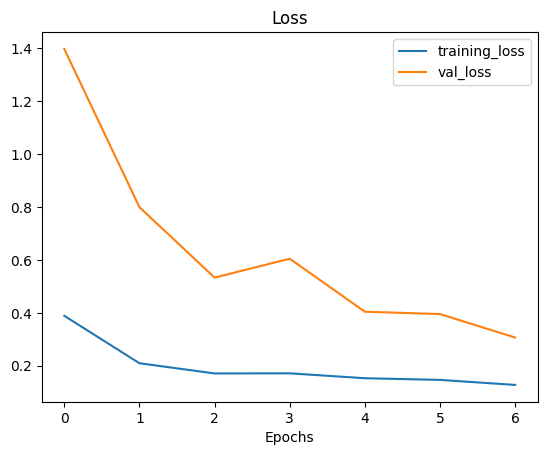

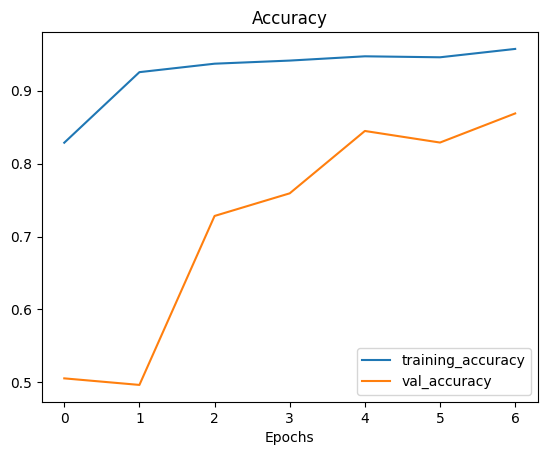

In [26]:
plot_loss_curves(history_resnet_2)

InceptionNet

In [27]:
from keras.applications.inception_v3 import InceptionV3

input_shape=(224,224,3)
batch_size=64

def build_model_inception():
    densenet = InceptionV3(
                        weights='imagenet',
                        include_top=False,
                        input_shape=input_shape,
                        )
    model = Sequential([densenet,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(256,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(128,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dense(64,activation='relu'),
                        layers.BatchNormalization(),
                        layers.Dropout(0.5),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

model_icv3 = build_model_inception()
model_icv3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ ?                           │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [28]:
tf.random.set_seed(42)
history_icv3 = model_icv3.fit(train_data,
    epochs = 8,
    steps_per_epoch = 512,
    validation_data =valid_data,
    validation_steps = 512
)

Epoch 1/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 381s 559ms/step - accuracy: 0.7198 - loss: 0.6065 - val_accuracy: 0.8092 - val_loss: 0.4594
Epoch 2/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 274s 535ms/step - accuracy: 0.9242 - loss: 0.1960 - val_accuracy: 0.7478 - val_loss: 0.7462
Epoch 3/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 279s 545ms/step - accuracy: 0.9364 - loss: 0.1601 - val_accuracy: 0.8466 - val_loss: 0.4044
Epoch 4/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 280s 547ms/step - accuracy: 0.9463 - loss: 0.1378 - val_accuracy: 0.8379 - val_loss: 0.4470
Epoch 5/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 276s 540ms/step - accuracy: 0.9540 - loss: 0.1281 - val_accuracy: 0.8134 - val_loss: 0.6144
Epoch 6/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 276s 540ms/step - accuracy: 0.9614 - loss: 0.1092 - val_accuracy: 0.7997 - val_loss: 0.6790
Epoch 7/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 277s 542ms/step - accuracy: 0.9610 - loss: 0.1099 - val_accuracy: 0.7806 - val_loss: 0.9432
Epoch 8/8
512/512 ━━━━━━━━━━━━━━━━━━━━ 280s 547ms/step - accuracy: 0.9615 - loss: 0

Accuracy: 0.9655

##Code for Prediction (Classifier)

In [29]:
import tensorflow as tf

def predict_image(model, img_path):

    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size=(224, 224))  # Resize to model input shape
    img = img / 255.0  # Normalize pixel values

    # Expand dimensions to match model input shape
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img)

    # Convert prediction probabilities to binary prediction
    binary_prediction = 1 if prediction > 0.5 else 0

    return binary_prediction


trained_model = model_icv3

img_path = '/content/Dataset/Train/Fake/fake_10014.jpg'


prediction = predict_image(trained_model, img_path)
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediction: 0


1/1 [==============================] - 9s 9s/step
Prediction: 0

In [ ]:
import tensorflow as tf

def predict_image(model, img_path):

    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size=(224, 224))  # Resize to model input shape
    img = img / 255.0  # Normalize pixel values

    # Expand dimensions to match model input shape
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img)

    # Convert prediction probabilities to binary prediction
    binary_prediction = 1 if prediction > 0.5 else 0

    return binary_prediction


trained_model = model_icv3

img_path = '/content/Dataset/Train/Real/real_10028.jpg'


prediction = predict_image(trained_model, img_path)
print("Prediction:", prediction)


1/1 [==============================] - 0s 149ms/step
Prediction: 1